In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np

from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf
from enum import Enum

from math import sqrt
import threading
import matplotlib.pyplot as plt
import time
from IPython import display

class FLAGS(Enum):
    batch_size = 128
    data_dir = './cifar10_data_karishma'
    use_fp16 = False
    train_dir = './cifar10_train_karishma'
    max_steps = 30000
    log_device_placement = False
    log_frequency = 10

# Process images of this size. Note that this differs from the original CIFAR
# image size of 32 x 32. If one alters this number, then the entire model
# architecture will change and any model would need to be retrained.
IMAGE_SIZE = 24

# Global constants describing the CIFAR-10 data set.
NUM_CLASSES = 10
NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN = 50000
NUM_EXAMPLES_PER_EPOCH_FOR_EVAL = 10000


def read_cifar10(filename_queue):
  """Reads and parses examples from CIFAR10 data files.

  Recommendation: if you want N-way read parallelism, call this function
  N times.  This will give you N independent Readers reading different
  files & positions within those files, which will give better mixing of
  examples.

  Args:
    filename_queue: A queue of strings with the filenames to read from.

  Returns:
    An object representing a single example, with the following fields:
      height: number of rows in the result (32)
      width: number of columns in the result (32)
      depth: number of color channels in the result (3)
      key: a scalar string Tensor describing the filename & record number
        for this example.
      label: an int32 Tensor with the label in the range 0..9.
      uint8image: a [height, width, depth] uint8 Tensor with the image data
  """

  class CIFAR10Record(object):
    pass
  result = CIFAR10Record()

  # Dimensions of the images in the CIFAR-10 dataset.
  # See http://www.cs.toronto.edu/~kriz/cifar.html for a description of the
  # input format.
  label_bytes = 1  # 2 for CIFAR-100
  result.height = 32
  result.width = 32
  result.depth = 3
  image_bytes = result.height * result.width * result.depth
  # Every record consists of a label followed by the image, with a
  # fixed number of bytes for each.
  record_bytes = label_bytes + image_bytes

  # Read a record, getting filenames from the filename_queue.  No
  # header or footer in the CIFAR-10 format, so we leave header_bytes
  # and footer_bytes at their default of 0.
  reader = tf.FixedLengthRecordReader(record_bytes=record_bytes)
  result.key, value = reader.read(filename_queue)

  # Convert from a string to a vector of uint8 that is record_bytes long.
  record_bytes = tf.decode_raw(value, tf.uint8)

  # The first bytes represent the label, which we convert from uint8->int32.
  result.label = tf.cast(
      tf.strided_slice(record_bytes, [0], [label_bytes]), tf.int32)

  # The remaining bytes after the label represent the image, which we reshape
  # from [depth * height * width] to [depth, height, width].
  depth_major = tf.reshape(
      tf.strided_slice(record_bytes, [label_bytes],
                       [label_bytes + image_bytes]),
      [result.depth, result.height, result.width])
  # Convert from [depth, height, width] to [height, width, depth].
  result.uint8image = tf.transpose(depth_major, [1, 2, 0])

  return result


def _generate_image_and_label_batch(image, label, min_queue_examples,
                                    batch_size, shuffle):
  """Construct a queued batch of images and labels.

  Args:
    image: 3-D Tensor of [height, width, 3] of type.float32.
    label: 1-D Tensor of type.int32
    min_queue_examples: int32, minimum number of samples to retain
      in the queue that provides of batches of examples.
    batch_size: Number of images per batch.
    shuffle: boolean indicating whether to use a shuffling queue.

  Returns:
    images: Images. 4D tensor of [batch_size, height, width, 3] size.
    labels: Labels. 1D tensor of [batch_size] size.
  """
  # Create a queue that shuffles the examples, and then
  # read 'batch_size' images + labels from the example queue.
  num_preprocess_threads = 16
  if shuffle:
    images, label_batch = tf.train.shuffle_batch(
        [image, label],
        batch_size=batch_size,
        num_threads=num_preprocess_threads,
        capacity=min_queue_examples + 3 * batch_size,
        min_after_dequeue=min_queue_examples)
  else:
    images, label_batch = tf.train.batch(
        [image, label],
        batch_size=batch_size,
        num_threads=num_preprocess_threads,
        capacity=min_queue_examples + 3 * batch_size)

  # Display the training images in the visualizer.
  tf.summary.image('images', images)

  return images, tf.reshape(label_batch, [batch_size])


def distorted_inputs_overloaded(data_dir, batch_size):
  """Construct distorted input for CIFAR training using the Reader ops.

  Args:
    data_dir: Path to the CIFAR-10 data directory.
    batch_size: Number of images per batch.

  Returns:
    images: Images. 4D tensor of [batch_size, IMAGE_SIZE, IMAGE_SIZE, 3] size.
    labels: Labels. 1D tensor of [batch_size] size.
  """
  filenames = [os.path.join(data_dir, 'data_batch_%d.bin' % i)
               for i in xrange(1, 6)]
  for f in filenames:
    if not tf.gfile.Exists(f):
      raise ValueError('Failed to find file: ' + f)

  # Create a queue that produces the filenames to read.
  filename_queue = tf.train.string_input_producer(filenames)

  # Read examples from files in the filename queue.
  read_input = read_cifar10(filename_queue)
  reshaped_image = tf.cast(read_input.uint8image, tf.float32)

  height = IMAGE_SIZE
  width = IMAGE_SIZE

  # Image processing for training the network. Note the many random
  # distortions applied to the image.

  # Randomly crop a [height, width] section of the image.
  distorted_image = tf.random_crop(reshaped_image, [height, width, 3])

  # Randomly flip the image horizontally.
  distorted_image = tf.image.random_flip_left_right(distorted_image)

  # Because these operations are not commutative, consider randomizing
  # the order their operation.
  # NOTE: since per_image_standardization zeros the mean and makes
  # the stddev unit, this likely has no effect see tensorflow#1458.
  distorted_image = tf.image.random_brightness(distorted_image,
                                               max_delta=63)
  distorted_image = tf.image.random_contrast(distorted_image,
                                             lower=0.2, upper=1.8)

  # Subtract off the mean and divide by the variance of the pixels.
  float_image = tf.image.per_image_standardization(distorted_image)

  # Set the shapes of tensors.
  float_image.set_shape([height, width, 3])
  read_input.label.set_shape([1])

  # Ensure that the random shuffling has good mixing properties.
  min_fraction_of_examples_in_queue = 0.4
  min_queue_examples = int(NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN *
                           min_fraction_of_examples_in_queue)
  print ('Filling queue with %d CIFAR images before starting to train. '
         'This will take a few minutes.' % min_queue_examples)

  # Generate a batch of images and labels by building up a queue of examples.
  return _generate_image_and_label_batch(float_image, read_input.label,
                                         min_queue_examples, batch_size,
                                         shuffle=True)


def inputs_overloaded(eval_data, data_dir, batch_size):
  """Construct input for CIFAR evaluation using the Reader ops.

  Args:
    eval_data: bool, indicating if one should use the train or eval data set.
    data_dir: Path to the CIFAR-10 data directory.
    batch_size: Number of images per batch.

  Returns:
    images: Images. 4D tensor of [batch_size, IMAGE_SIZE, IMAGE_SIZE, 3] size.
    labels: Labels. 1D tensor of [batch_size] size.
  """
  if not eval_data:
    filenames = [os.path.join(data_dir, 'data_batch_%d.bin' % i)
                 for i in xrange(1, 6)]
    num_examples_per_epoch = NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN
  else:
    filenames = [os.path.join(data_dir, 'test_batch.bin')]
    num_examples_per_epoch = NUM_EXAMPLES_PER_EPOCH_FOR_EVAL

  for f in filenames:
    if not tf.gfile.Exists(f):
      raise ValueError('Failed to find file: ' + f)

  # Create a queue that produces the filenames to read.
  filename_queue = tf.train.string_input_producer(filenames)

  # Read examples from files in the filename queue.
  read_input = read_cifar10(filename_queue)
  reshaped_image = tf.cast(read_input.uint8image, tf.float32)

  height = IMAGE_SIZE
  width = IMAGE_SIZE

  # Image processing for evaluation.
  # Crop the central [height, width] of the image.
  resized_image = tf.image.resize_image_with_crop_or_pad(reshaped_image,
                                                         height, width)

  # Subtract off the mean and divide by the variance of the pixels.
  float_image = tf.image.per_image_standardization(resized_image)

  # Set the shapes of tensors.
  float_image.set_shape([height, width, 3])
  read_input.label.set_shape([1])

  # Ensure that the random shuffling has good mixing properties.
  min_fraction_of_examples_in_queue = 0.4
  min_queue_examples = int(num_examples_per_epoch *
                           min_fraction_of_examples_in_queue)

  # Generate a batch of images and labels by building up a queue of examples.
  return _generate_image_and_label_batch(float_image, read_input.label,
                                         min_queue_examples, batch_size,
                                         shuffle=False)


In [2]:
import argparse
import os
import re
import sys
import tarfile

from six.moves import urllib
import tensorflow as tf
from enum import Enum

#import cifar10_input

# parser = argparse.ArgumentParser()

# # Basic model parameters.
# parser.add_argument('--batch_size', type=int, default=128,
#                     help='Number of images to process in a batch.')

# parser.add_argument('--data_dir', type=str, default='/tmp/cifar10_data',
#                     help='Path to the CIFAR-10 data directory.')

# parser.add_argument('--use_fp16', type=bool, default=False,
#                     help='Train the model using fp16.')

# FLAGS = parser.parse_args()

# Global constants describing the CIFAR-10 data set.
# IMAGE_SIZE = cifar10_input.IMAGE_SIZE
# NUM_CLASSES = cifar10_input.NUM_CLASSES
# NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN = cifar10_input.NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN
# NUM_EXAMPLES_PER_EPOCH_FOR_EVAL = cifar10_input.NUM_EXAMPLES_PER_EPOCH_FOR_EVAL


# Constants describing the training process.
MOVING_AVERAGE_DECAY = 0.9999     # The decay to use for the moving average.
NUM_EPOCHS_PER_DECAY = 350.0      # Epochs after which learning rate decays.
LEARNING_RATE_DECAY_FACTOR = 0.1  # Learning rate decay factor.
INITIAL_LEARNING_RATE = 0.1       # Initial learning rate.

# If a model is trained with multiple GPUs, prefix all Op names with tower_name
# to differentiate the operations. Note that this prefix is removed from the
# names of the summaries when visualizing a model.
TOWER_NAME = 'tower'

DATA_URL = 'http://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz'


def _activation_summary(x):
  """Helper to create summaries for activations.

  Creates a summary that provides a histogram of activations.
  Creates a summary that measures the sparsity of activations.

  Args:
    x: Tensor
  Returns:
    nothing
  """
  # Remove 'tower_[0-9]/' from the name in case this is a multi-GPU training
  # session. This helps the clarity of presentation on tensorboard.
  tensor_name = re.sub('%s_[0-9]*/' % TOWER_NAME, '', x.op.name)
  tf.summary.histogram(tensor_name + '/activations', x)
  tf.summary.scalar(tensor_name + '/sparsity',
                                       tf.nn.zero_fraction(x))


def _variable_on_cpu(name, shape, initializer):
  """Helper to create a Variable stored on CPU memory.

  Args:
    name: name of the variable
    shape: list of ints
    initializer: initializer for Variable

  Returns:
    Variable Tensor
  """
  with tf.device('/cpu:0'):
    dtype = tf.float16 if FLAGS.use_fp16.value else tf.float32
    var = tf.get_variable(name, shape, initializer=initializer, dtype=dtype)
  return var


def _variable_with_weight_decay(name, shape, stddev, wd):
  """Helper to create an initialized Variable with weight decay.

  Note that the Variable is initialized with a truncated normal distribution.
  A weight decay is added only if one is specified.

  Args:
    name: name of the variable
    shape: list of ints
    stddev: standard deviation of a truncated Gaussian
    wd: add L2Loss weight decay multiplied by this float. If None, weight
        decay is not added for this Variable.

  Returns:
    Variable Tensor
  """
  dtype = tf.float16 if FLAGS.use_fp16.value else tf.float32
  var = _variable_on_cpu(
      name,
      shape,
      tf.truncated_normal_initializer(stddev=stddev, dtype=dtype))
  if wd is not None:
    weight_decay = tf.multiply(tf.nn.l2_loss(var), wd, name='weight_loss')
    tf.add_to_collection('losses', weight_decay)
  return var


def distorted_inputs():
  """Construct distorted input for CIFAR training using the Reader ops.

  Returns:
    images: Images. 4D tensor of [batch_size, IMAGE_SIZE, IMAGE_SIZE, 3] size.
    labels: Labels. 1D tensor of [batch_size] size.

  Raises:
    ValueError: If no data_dir
  """
  if not FLAGS.data_dir.value:
    raise ValueError('Please supply a data_dir')
  data_dir = os.path.join(FLAGS.data_dir.value, 'cifar-10-batches-bin')
  images, labels = distorted_inputs_overloaded(data_dir=data_dir,
                                                  batch_size=FLAGS.batch_size.value)
  if FLAGS.use_fp16.value:
    images = tf.cast(images, tf.float16)
    labels = tf.cast(labels, tf.float16)
  return images, labels


def inputs(eval_data):
  """Construct input for CIFAR evaluation using the Reader ops.

  Args:
    eval_data: bool, indicating if one should use the train or eval data set.

  Returns:
    images: Images. 4D tensor of [batch_size, IMAGE_SIZE, IMAGE_SIZE, 3] size.
    labels: Labels. 1D tensor of [batch_size] size.

  Raises:
    ValueError: If no data_dir
  """
  if not FLAGS.data_dir.value:
    raise ValueError('Please supply a data_dir')
  data_dir = os.path.join(FLAGS.data_dir.value, 'cifar-10-batches-bin')
  images, labels = inputs_overloaded(eval_data=eval_data,
                                        data_dir=data_dir,
                                        batch_size=FLAGS.batch_size.value)
  if FLAGS.use_fp16.value:
    images = tf.cast(images, tf.float16)
    labels = tf.cast(labels, tf.float16)
  return images, labels


def inference(images):
  """Build the CIFAR-10 model.

  Args:
    images: Images returned from distorted_inputs() or inputs().

  Returns:
    Logits.
  """
  # We instantiate all variables using tf.get_variable() instead of
  # tf.Variable() in order to share variables across multiple GPU training runs.
  # If we only ran this model on a single GPU, we could simplify this function
  # by replacing all instances of tf.get_variable() with tf.Variable().
  #
  # conv1

  #filter shape has height, width, channels, number of filters
  
  # Create list of layers
  layers = {}
  with tf.variable_scope('conv1') as scope:
    kernel = _variable_with_weight_decay('weights',
                                         shape=[5, 5, 3, 64],
                                         stddev=5e-2,
                                         wd=0.0)
    conv = tf.nn.conv2d(images, kernel, [1, 1, 1, 1], padding='SAME')
    biases = _variable_on_cpu('biases', [64], tf.constant_initializer(0.0))
    pre_activation = tf.nn.bias_add(conv, biases)
    # Add to list of layers
    layers['conv1_pre_relu'] = pre_activation
    conv1 = tf.nn.relu(pre_activation, name=scope.name)
    _activation_summary(conv1)
    layers['conv1'] = conv1

  # pool1
  pool1 = tf.nn.max_pool(conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1],
                         padding='SAME', name='pool1')
  layers['pool1'] = pool1
  # norm1
  norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,
                    name='norm1')
  layers['norm1'] = norm1

  # conv2
  with tf.variable_scope('conv2') as scope:
    kernel = _variable_with_weight_decay('weights',
                                         shape=[5, 5, 64, 64],
                                         stddev=5e-2,
                                         wd=0.0)
    conv = tf.nn.conv2d(norm1, kernel, [1, 1, 1, 1], padding='SAME')
    biases = _variable_on_cpu('biases', [64], tf.constant_initializer(0.1))
    pre_activation = tf.nn.bias_add(conv, biases)
    layers['conv2_pre_relu'] = pre_activation
    conv2 = tf.nn.relu(pre_activation, name=scope.name)  
    layers['conv2'] = conv2
    _activation_summary(conv2)

  # norm2
  norm2 = tf.nn.lrn(conv2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,
                    name='norm2')
  layers['norm2'] = norm2
  # pool2
  pool2 = tf.nn.max_pool(norm2, ksize=[1, 3, 3, 1],
                         strides=[1, 2, 2, 1], padding='SAME', name='pool2')
  layers['pool2'] = pool2

  # local3
  with tf.variable_scope('local3') as scope:
    # Move everything into depth so we can perform a single matrix multiply.
    reshape = tf.reshape(pool2, [FLAGS.batch_size.value, -1])
    dim = reshape.get_shape()[1].value
    weights = _variable_with_weight_decay('weights', shape=[dim, 384],
                                          stddev=0.04, wd=0.004)
    biases = _variable_on_cpu('biases', [384], tf.constant_initializer(0.1))
    pre_activation = tf.matmul(reshape, weights) + biases
    layers['local3_pre_relu'] = pre_activation
    local3 = tf.nn.relu(pre_activation, name=scope.name)
    layers['local3'] = local3

    _activation_summary(local3)

  # local4
  with tf.variable_scope('local4') as scope:
    weights = _variable_with_weight_decay('weights', shape=[384, 192],
                                          stddev=0.04, wd=0.004)
    biases = _variable_on_cpu('biases', [192], tf.constant_initializer(0.1))
    pre_activation = tf.matmul(local3, weights) + biases
    layers['local4_pre_relu'] = pre_activation
    local4 = tf.nn.relu(pre_activation, name=scope.name)
    layers['local4'] = local4
    _activation_summary(local4)

  # linear layer(WX + b),
  # We don't apply softmax here because
  # tf.nn.sparse_softmax_cross_entropy_with_logits accepts the unscaled logits
  # and performs the softmax internally for efficiency.
  with tf.variable_scope('softmax_linear') as scope:
    weights = _variable_with_weight_decay('weights', [192, NUM_CLASSES],
                                          stddev=1/192.0, wd=0.0)
    biases = _variable_on_cpu('biases', [NUM_CLASSES],
                              tf.constant_initializer(0.0))
    softmax_linear = tf.add(tf.matmul(local4, weights), biases, name=scope.name)
    layers['soft_max_out'] = softmax_linear
    _activation_summary(softmax_linear)

  return softmax_linear, layers
  #return softmax_linear


def loss(logits, labels):
  """Add L2Loss to all the trainable variables.

  Add summary for "Loss" and "Loss/avg".
  Args:
    logits: Logits from inference().
    labels: Labels from distorted_inputs or inputs(). 1-D tensor
            of shape [batch_size]

  Returns:
    Loss tensor of type float.
  """
  # Calculate the average cross entropy loss across the batch.
  labels = tf.cast(labels, tf.int64)
  cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
      labels=labels, logits=logits, name='cross_entropy_per_example')
  cross_entropy_mean = tf.reduce_mean(cross_entropy, name='cross_entropy')
  tf.add_to_collection('losses', cross_entropy_mean)

  # The total loss is defined as the cross entropy loss plus all of the weight
  # decay terms (L2 loss).
  return tf.add_n(tf.get_collection('losses'), name='total_loss')


def _add_loss_summaries(total_loss):
  """Add summaries for losses in CIFAR-10 model.

  Generates moving average for all losses and associated summaries for
  visualizing the performance of the network.

  Args:
    total_loss: Total loss from loss().
  Returns:
    loss_averages_op: op for generating moving averages of losses.
  """
  # Compute the moving average of all individual losses and the total loss.
  loss_averages = tf.train.ExponentialMovingAverage(0.9, name='avg')
  losses = tf.get_collection('losses')
  loss_averages_op = loss_averages.apply(losses + [total_loss])

  # Attach a scalar summary to all individual losses and the total loss; do the
  # same for the averaged version of the losses.
  for l in losses + [total_loss]:
    # Name each loss as '(raw)' and name the moving average version of the loss
    # as the original loss name.
    tf.summary.scalar(l.op.name + ' (raw)', l)
    tf.summary.scalar(l.op.name, loss_averages.average(l))

  return loss_averages_op


def cifar10_train(total_loss, global_step):
  """Train CIFAR-10 model.

  Create an optimizer and apply to all trainable variables. Add moving
  average for all trainable variables.

  Args:
    total_loss: Total loss from loss().
    global_step: Integer Variable counting the number of training steps
      processed.
  Returns:
    train_op: op for training.
  """
  # Variables that affect learning rate.
  num_batches_per_epoch = NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN / FLAGS.batch_size.value
  decay_steps = int(num_batches_per_epoch * NUM_EPOCHS_PER_DECAY)

  # Decay the learning rate exponentially based on the number of steps.
  lr = tf.train.exponential_decay(INITIAL_LEARNING_RATE,
                                  global_step,
                                  decay_steps,
                                  LEARNING_RATE_DECAY_FACTOR,
                                  staircase=True)
  tf.summary.scalar('learning_rate', lr)

  # Generate moving averages of all losses and associated summaries.
  loss_averages_op = _add_loss_summaries(total_loss)

  # Compute gradients.
  with tf.control_dependencies([loss_averages_op]):
    opt = tf.train.GradientDescentOptimizer(lr)
    grads = opt.compute_gradients(total_loss)

  # Apply gradients.
  apply_gradient_op = opt.apply_gradients(grads, global_step=global_step)

  # Add histograms for trainable variables.
  for var in tf.trainable_variables():
    tf.summary.histogram(var.op.name, var)

  # Add histograms for gradients.
  for grad, var in grads:
    if grad is not None:
      tf.summary.histogram(var.op.name + '/gradients', grad)

  # Track the moving averages of all trainable variables.
  variable_averages = tf.train.ExponentialMovingAverage(
      MOVING_AVERAGE_DECAY, global_step)
  variables_averages_op = variable_averages.apply(tf.trainable_variables())

  with tf.control_dependencies([apply_gradient_op, variables_averages_op]):
    train_op = tf.no_op(name='train')

  return train_op


def maybe_download_and_extract():
  """Download and extract the tarball from Alex's website."""
  dest_directory = FLAGS.data_dir.value
  if not os.path.exists(dest_directory):
    os.makedirs(dest_directory)
  filename = DATA_URL.split('/')[-1]
  filepath = os.path.join(dest_directory, filename)
  if not os.path.exists(filepath):
    def _progress(count, block_size, total_size):
      sys.stdout.write('\r>> Downloading %s %.1f%%' % (filename,
          float(count * block_size) / float(total_size) * 100.0))
      sys.stdout.flush()
    filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath, _progress)
    print()
    statinfo = os.stat(filepath)
    print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
  extracted_dir_path = os.path.join(dest_directory, 'cifar-10-batches-bin')
  if not os.path.exists(extracted_dir_path):
    tarfile.open(filepath, 'r:gz').extractall(dest_directory)

In [3]:
## EVALUATION OF ACCURACY

from datetime import datetime
import math
import time

import numpy as np
import tensorflow as tf
from enum import Enum

class EVALFLAGS(Enum):
    eval_dir = './cifar10_eval_karishma'
    eval_data = 'test'
    checkpoint_dir = './cifar10_train_karishma'
    eval_interval_secs = 300
    num_examples = 10000
    run_once = False

def eval_once(saver, summary_writer, top_k_op, summary_op):
  """Run Eval once.
  Args:
    saver: Saver.
    summary_writer: Summary writer.
    top_k_op: Top K op.
    summary_op: Summary op.
  """
  with tf.Session() as sess:
    ckpt = tf.train.get_checkpoint_state(EVALFLAGS.checkpoint_dir.value)
    if ckpt and ckpt.model_checkpoint_path:
      # Restores from checkpoint
      saver.restore(sess, ckpt.model_checkpoint_path)
      # Assuming model_checkpoint_path looks something like:
      #   /my-favorite-path/cifar10_train/model.ckpt-0,
      # extract global_step from it.
      global_step = ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1]
    else:
      print('No checkpoint file found')
      return

    # Start the queue runners.
    coord = tf.train.Coordinator()
    try:
      threads = []
      for qr in tf.get_collection(tf.GraphKeys.QUEUE_RUNNERS):
        threads.extend(qr.create_threads(sess, coord=coord, daemon=True,
                                         start=True))

      num_iter = int(math.ceil(EVALFLAGS.num_examples.value / FLAGS.batch_size.value))
      true_count = 0  # Counts the number of correct predictions.
      total_sample_count = num_iter * FLAGS.batch_size.value
      step = 0
      while step < num_iter and not coord.should_stop():
        predictions = sess.run([top_k_op])
        true_count += np.sum(predictions)
        step += 1

      # Compute precision @ 1.
      precision = true_count / total_sample_count
      print('%s: precision @ 1 = %.3f' % (datetime.now(), precision))

      summary = tf.Summary()
      summary.ParseFromString(sess.run(summary_op))
      summary.value.add(tag='Precision @ 1', simple_value=precision)
      summary_writer.add_summary(summary, global_step)
    except Exception as e:  # pylint: disable=broad-except
      coord.request_stop(e)

    coord.request_stop()
    coord.join(threads, stop_grace_period_secs=10)


def evaluate():
  """Eval CIFAR-10 for a number of steps."""
  with tf.Graph().as_default() as g:
    # Get images and labels for CIFAR-10.
    eval_data = EVALFLAGS.eval_data.value == 'test'
    images, labels = inputs(eval_data=eval_data)

    # Build a Graph that computes the logits predictions from the
    # inference model.
    logits, layers = inference(images)

    # Calculate predictions.
    top_k_op = tf.nn.in_top_k(logits, labels, 1)

    # Restore the moving average version of the learned variables for eval.
    variable_averages = tf.train.ExponentialMovingAverage(MOVING_AVERAGE_DECAY)
    variables_to_restore = variable_averages.variables_to_restore()
    saver = tf.train.Saver(variables_to_restore)

    # Build the summary operation based on the TF collection of Summaries.
    summary_op = tf.summary.merge_all()

    summary_writer = tf.summary.FileWriter(EVALFLAGS.eval_dir.value, g)

    while True:
      eval_once(saver, summary_writer, top_k_op, summary_op)
      if EVALFLAGS.run_once:
        break
      time.sleep(EVALFLAGS.eval_interval_secs.value)


#def main(argv=None):  # pylint: disable=unused-argument
#maybe_download_and_extract()
if tf.gfile.Exists(EVALFLAGS.eval_dir.value):
  tf.gfile.DeleteRecursively(EVALFLAGS.eval_dir.value)
tf.gfile.MakeDirs(EVALFLAGS.eval_dir.value)
evaluate()

INFO:tensorflow:Restoring parameters from ./cifar10_train_karishma/model.ckpt-30000
2018-02-28 04:59:07.919316: precision @ 1 = 0.846


In [4]:
def find_gradient(conv_layer, filter_index, batch_size, X):
    if (len(conv_layer.shape) == 2):
        # This is a fully connected layer with 2-dimentions
        target_pixel = tf.slice(conv_layer, begin=[0, filter_index],size=[batch_size, 1])
        grad = tf.gradients(target_pixel, X)
        return grad, target_pixel
    else:
        # This is a convolutional layer with 4-dimentions
        mid_height = conv_layer.get_shape().as_list()[1] // 2
        mid_width = conv_layer.get_shape().as_list()[2] // 2
        target_pixel = tf.slice(conv_layer, begin=[0, mid_height, mid_width, filter_index],size=[batch_size, 1, 1, 1])
        grad = tf.gradients(target_pixel, X)
        return grad, target_pixel

In [5]:
with tf.Graph().as_default() as g:
    # Get images and labels for CIFAR-10.
    eval_data = EVALFLAGS.eval_data.value == 'test'
    X = tf.placeholder(tf.float32, [FLAGS.batch_size.value, IMAGE_SIZE, IMAGE_SIZE, 3])
    
    # Build a Graph that computes the logits predictions from the
    # inference model.
    logits, layers = inference(X)

    # Restore the moving average version of the learned variables for eval.
    variable_averages = tf.train.ExponentialMovingAverage(MOVING_AVERAGE_DECAY)
    variables_to_restore = variable_averages.variables_to_restore()
    saver = tf.train.Saver(variables_to_restore)
    
    # Start the session
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.15)
    sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
    
    ckpt = tf.train.get_checkpoint_state(EVALFLAGS.checkpoint_dir.value)
    if ckpt and ckpt.model_checkpoint_path:
      # Restores from checkpoint
      saver.restore(sess, ckpt.model_checkpoint_path)
      # Assuming model_checkpoint_path looks something like:
      #   /my-favorite-path/cifar10_train/model.ckpt-0,
      # extract global_step from it.
      global_step = ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1]
    else:
      print('No checkpoint file found')
    conv_weights = g.get_tensor_by_name('conv1/weights:0')
    last_weights = g.get_tensor_by_name('softmax_linear/weights:0')

INFO:tensorflow:Restoring parameters from ./cifar10_train_karishma/model.ckpt-30000


## Gradient Descent on Classifier:

In [6]:
def activation_maximization(sess, conv_layer, target_filter_index, to_display = False, reg = 1, 
                            learning_rate_class = 0.0001, steps = 100, noise_coeff = 0.1, true_weights = None):
    gradient, target_pixel = find_gradient(conv_layer, target_filter_index, FLAGS.batch_size.value, X)
    n = 10
    canvas = np.empty((IMAGE_SIZE * n, IMAGE_SIZE * n, 3))    
    accumulateClassifier = np.zeros((FLAGS.batch_size.value, IMAGE_SIZE, IMAGE_SIZE, 3))
    noise_img = np.random.rand(FLAGS.batch_size.value, IMAGE_SIZE, IMAGE_SIZE, 3)
    img = noise_img
    accumulateClassifier[:, :, :, :] = 0
    loss = []
    objectives = []
    for k in range(steps):
        for inter_loop in range(10):
            g, activation = sess.run([gradient, target_pixel], feed_dict={X: img})
            # Accumulate and Normalize the gradient
            grad_reg = g[0] - reg*img
            accumulateClassifier = 0.1 * grad_reg ** 2 + 0.9 * accumulateClassifier 
            normalized_class_grad = grad_reg / np.sqrt(accumulateClassifier + 1e-8)
            # Add the gradient from classifier
            noise = np.random.normal(size=(FLAGS.batch_size.value, IMAGE_SIZE, IMAGE_SIZE, 3))
            img += (learning_rate_class) * (normalized_class_grad + noise_coeff*noise)
        # Calculated the loss if the desired input in given for first layer
        if (true_weights is not None):
            mean_batch = np.mean(img, axis = 0)
            this_loss = np.sum(np.square(mean_batch[10:15,10:15,:]*reg - true_weights))
            loss.append(this_loss)
        this_objective = np.sum(activation - reg*np.sqrt(np.sum(np.square(img), axis = (1,2,3)))/2)
        objectives.append(this_objective)
        # Display the image
        if (to_display):
            for i in range(n):
                for j in range(n):
                    # Draw the generated digits
                    canvas[i * IMAGE_SIZE:(i + 1) * IMAGE_SIZE, j * IMAGE_SIZE:(j + 1) * IMAGE_SIZE, :] = img[i * n + j]
            plt.figure(figsize=(n, n))
            plt.imshow(canvas)
            plt.show()
            print('iter=' + str(k))
            print('Class Gradient range  =' + str(np.min(normalized_class_grad)) + " " + str(np.max(normalized_class_grad)))
            display.clear_output(wait=True)
            time.sleep(0.2)
        
    return img, loss, objectives, canvas

In [7]:
# Get the actual filter of first layers
first_layer = sess.run(conv_weights)

In [ ]:
result_first_layer = []
# activation_maximization on several filters, plot & compare with actual filter
for target_filter_index in range(64):
    img,  = activation_maximization(sess, layers['conv1_pre_relu'], target_filter_index, reg = 1, learning_rate_class = 1e-2, steps = 50)
    # Get the average gradient descent result of a batch
    mean_batch = np.mean(img, axis = 0)
    # Plot
    plt.subplot(2, 2, 1)
    plt.imshow(mean_batch[10:15,10:15,:])
    plt.subplot(2, 2, 2)
    plt.imshow(first_layer[:,:,:,target_filter_index])
#     plt.savefig('FirstLayerACResultImgs/' + str(target_filter_index) +'.jpg')
    plt.show()
    result_first_layer.append(img)

In [ ]:
# Plot the first layer
target_filter_index = 3
re = 1
lr = 5e-3
true_weights = first_layer[:,:,:,target_filter_index]
img, losses, objectives, canvas = activation_maximization(sess, layers['conv1'], target_filter_index, 
                                                          to_display = True, reg = re, 
                                                          learning_rate_class = lr, steps = 50, noise_coeff = 0)
# Get the average gradient descent result of a batch
mean_batch = np.mean(img, axis = 0)
# Plot
plt.subplot(2, 2, 1)
plt.imshow(mean_batch[10:15,10:15,:]*re)
plt.subplot(2, 2, 2)
plt.imshow(first_layer[:,:,:,target_filter_index])
#     plt.savefig('FirstLayerACResultImgs/'+ 'TunningResult/' + 'reg'+str(re)+'lr' +str(lr) +'.jpg')
plt.show()

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(canvas)
plt.show()

In [ ]:
# Plot the loss and objective on the same graph
fig, ax1 = plt.subplots()

ax1.set_xlabel('iteration (t)')
ax1.set_ylabel('losses', color='red')
ax1.plot(losses, color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()  
ax2.set_ylabel('objectives', color='blue') 
ax2.plot(objectives, color='tab:blue')
ax2.tick_params(axis='y', labelcolor='blue')

fig.tight_layout()  
plt.show()

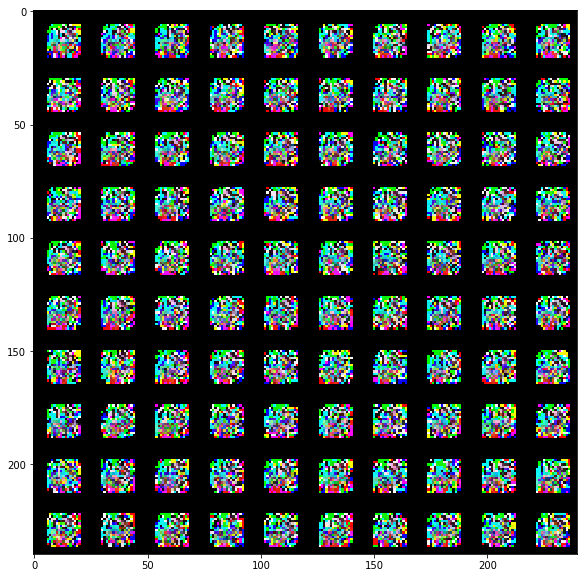

In [9]:
# Plot the second layer
target_filter_index = 62
re = 1
lr = 5e-4
img, losses, objectives, canvas = activation_maximization(sess, layers['conv2_pre_relu'], target_filter_index, to_display = True, reg = re, learning_rate_class = lr, steps = 300, noise_coeff = 0)
# Get the average gradient descent result of a batch
# mean_batch = np.mean(img, axis = 0)
# Plot
# plt.subplot(2, 2, 1)
# plt.imshow(mean_batch[10:15,10:15,:]*re)
# plt.subplot(2, 2, 2)
# plt.imshow(first_layer[:,:,:,target_filter_index])
#     plt.savefig('FirstLayerACResultImgs/'+ 'TunningResult/' + 'reg'+str(re)+'lr' +str(lr) +'.jpg')
plt.figure(figsize=(10, 10))
plt.imshow(canvas)
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


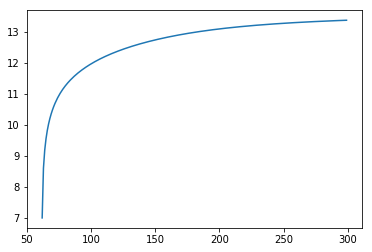

In [10]:
objectives_log = np.array(np.log(objectives))
plt.plot(objectives_log)
plt.show()

0


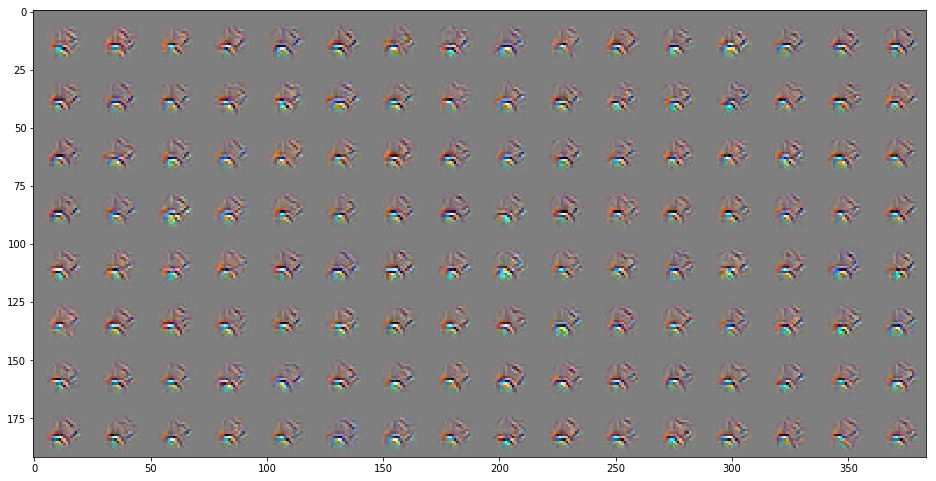

In [11]:
w = 8
h = 16
canvas = np.empty((24 * w, 24 * h, 3))
# Display by different Batch
for filter_index in range(1):
    print(filter_index)
    for img_index_in_batch in range(128):
        pic = img[img_index_in_batch]
        for i in range(3):
            color_layer = pic[:,:,i]
            min_pixel = np.min(color_layer)
            max_pixel = np.max(color_layer)
            color_layer[color_layer < 0] = 0.5*color_layer[color_layer < 0]/(- min_pixel)
            color_layer[color_layer >= 0] = 0.5*color_layer[color_layer >= 0]/max_pixel
            color_layer = color_layer + 0.5
            # Scale the upper
            pic[:,:,i] = color_layer
        k = img_index_in_batch // h
        p = img_index_in_batch - k*h
        canvas[k * 24:(k + 1) * 24, p * 24:(p + 1) * 24, :] = pic
    plt.figure(figsize=(w*2, h*2))
    plt.imshow(canvas)
    plt.show()

In [ ]:
plt.imshow(np.mean(img, axis = 0)[:,:,0],cmap=plt.get_cmap('Greys'))
plt.show()
plt.imshow(np.mean(img, axis = 0)[:,:,1],cmap=plt.get_cmap('Greys'))
plt.show()
plt.imshow(np.mean(img, axis = 0)[:,:,2],cmap=plt.get_cmap('Greys'))
plt.show()

In [ ]:
mean_img = np.mean(img, axis = 0)
plt.figure(figsize=(15, 15))
plt.subplot(1, 4, 1)
plt.imshow(mean_img)
plt.subplot(1, 4, 2)
plt.imshow(mean_img[:,:,0],cmap=plt.get_cmap('Greys'))
plt.subplot(1, 4, 3)
plt.imshow(mean_img[:,:,1],cmap=plt.get_cmap('Greys'))
plt.subplot(1, 4, 4)
plt.imshow(mean_img[:,:,2],cmap=plt.get_cmap('Greys'))
plt.show()
plt.savefig('SecondLayerACResultImgs/' +str(i) +'.jpg')

In [ ]:
results = []
result_objective = []
for target_filter_index in range(64):
    img, losses, objectives, canvas = activation_maximization(sess, layers['conv2_pre_relu'], target_filter_index, 
                                                              reg = 1, learning_rate_class = 1e-3, steps = 300, 
                                                              noise_coeff = 0)
    # Get the average gradient descent result of a batch
    results.append(img)
    result_objective.append(objectives)
    mean_img = np.mean(img, axis = 0)
    # Plot
    print(target_filter_index)
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 4, 1)
    plt.imshow(mean_img)
    plt.subplot(1, 4, 2)
    plt.imshow(mean_img[:,:,0],cmap=plt.get_cmap('Greys'))
    plt.subplot(1, 4, 3)
    plt.imshow(mean_img[:,:,1],cmap=plt.get_cmap('Greys'))
    plt.subplot(1, 4, 4)
    plt.imshow(mean_img[:,:,2],cmap=plt.get_cmap('Greys'))
#     plt.savefig('SecondLayerACResultImgs/' +str(target_filter_index) +'.jpg')
    plt.show()
results = np.array(results)
np.save('SecondLayerAMResultBatch', results)
result_objective = np.array(result_objective)
np.save('SecondLayerAMResultActivations', result_objective)

In [ ]:
results = np.array(results)
np.save('SecondLayerAMResultBatch', results)
result_objective = np.array(result_objective)
np.save('SecondLayerAMResultActivations', result_objective)

# Some exploration on gradients

In [ ]:
for target_class in range(10):
    ## Check Gredient end-to-end
    start = layers['conv2']
    end = tf.slice(layers['soft_max_out'], begin=[0, target_class],size=[FLAGS.batch_size.value, 1])
    target_grad = tf.gradients(end, start)
    ## Run the sess
    noise_img = np.random.rand(FLAGS.batch_size.value, IMAGE_SIZE, IMAGE_SIZE, 3)
    g = sess.run([target_grad], feed_dict={X: noise_img})
    g = g[0][0]
    filter_index = 6
    target_gradient = g[:,:,:,filter_index]
    print(target_class, np.max(target_gradient), np.min(target_gradient), np.mean(target_gradient))

In [ ]:
last_layer = sess.run(last_weights)

In [ ]:
np.where(last_layer[:,5] == np.max(last_layer[:,5] ))

In [ ]:
last_layer[:,5]